In [29]:
import sys
sys.path.append("../../")

In [30]:
import numpy as np
import torch

import matplotlib as mpl
cmap=mpl.colormaps["tab10"]
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

from botorch.utils.sampling import draw_sobol_samples, sample_simplex
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.test_functions.multi_objective import GMM, BraninCurrin
from botorch.utils.multi_objective.box_decompositions.dominated import DominatedPartitioning

from plotting import plot_pareto_space

tkwargs = {"dtype": torch.double, "device": torch.device("cpu"),}

In [32]:
# define problem
problem = BraninCurrin(negate=True).to(**tkwargs)
# problem = GMM(negate=True).to(**tkwargs)
ref_point = torch.tensor([0., 0.], **tkwargs)
n_objs = problem.num_objectives

In [31]:
def generate_initial_data(problem, n=6):
    # generate training data
    train_x = draw_sobol_samples(bounds=problem.bounds, n=n, q=1).squeeze(1)
    train_obj = problem(train_x)
    return train_x, train_obj

In [33]:
init_x, init_y = generate_initial_data(problem, n=60)

x_obs, y_obs = init_x, init_y

num_samples = 50
# only plot the first two dimensions
xx, yy = np.meshgrid(
    np.linspace(
        *problem.bounds.t()[0], num_samples
    ),
    np.linspace(
        *problem.bounds.t()[1], num_samples
    ),
)
input_data = np.vstack((xx.flatten(), yy.flatten())).T
input_data = torch.from_numpy(input_data)
output_data = problem(input_data)

In [34]:
# To polar coordinates
def cart2pol(x, y):
    rho = torch.sqrt(x**2 + y**2)
    phi = torch.arctan2(x, y)
    return (rho.reshape(-1, 1), phi.reshape(-1, 1))

def pol2cart(rho, phi):
    x = rho * torch.cos(phi)
    y = rho * torch.sin(phi)
    return (x, y)

In [35]:
class MLP(torch.nn.Module):

    def __init__(
        self,
        input_dim,
        output_dim,
        device="cpu:0",
        dtype=torch.double,
    ) -> None:
        super().__init__()
        self.tkwargs = {"device": device, "dtype": dtype}

        self.layers = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, output_dim),
        )

    def forward(self, x):
        logits = self.layers(x)
        return logits

## Generate training data

In [36]:
def split_good_bad(X, y, gamma):
    rhos, _ = cart2pol(y[:, 1], y[:, 0])
    rhos = -rhos

    tau = torch.quantile(torch.unique(rhos), q=gamma)
    z = torch.less(rhos, tau)

    z_idx = z.squeeze()

    x1, y1, z1 = X[z_idx], y[z_idx], z[z_idx]
    x0, y0, z0 = X, y, torch.zeros_like(z)

    w1 = (tau - rhos)[z_idx]
    # sometimes w1 is empty
    w1 = w1 / torch.mean(w1) if len(w1) else w1
    w0 = 1 - z0.int()

    x = torch.concat([x1, x0], axis=0)
    y = torch.concat([y1, y0], axis=0)
    z = torch.concat([z1, z0], axis=0)
    s1 = x1.shape[0]
    s0 = x0.shape[0]

    w = torch.concat([w1 * (s1 + s0) / s1, w0 * (s1 + s0) / s0], axis=0)
    w = w / torch.mean(w)

    return x, y, z, w 

### Normalize ys with ideal and nadir point

In [37]:
def compute_ideal_pt(y_obs):
    ideal_pt, _ = y_obs.max(dim=0)
    return ideal_pt

def compute_nadir_pt(y_obs):
    nadir, _ = y_obs.min(dim=0)
    return nadir

def normalize(y_obs):
    # normalize the data
    nadir_pt = compute_nadir_pt(y_obs)
    ideal_pt = compute_ideal_pt(y_obs)
    return (y_obs - nadir_pt) / (ideal_pt - nadir_pt)

In [42]:
ideal_pt = compute_ideal_pt(y_obs)
nadir_pt = compute_nadir_pt(y_obs)
y_obs = normalize(y_obs)

rhos, phis = cart2pol(y_obs[:, 1], y_obs[:, 0])

pareto = is_non_dominated(y_obs)
bd = DominatedPartitioning(ref_point=ref_point, Y=y_obs)

u, l = bd.hypercell_bounds

### Associate data with reference vectors

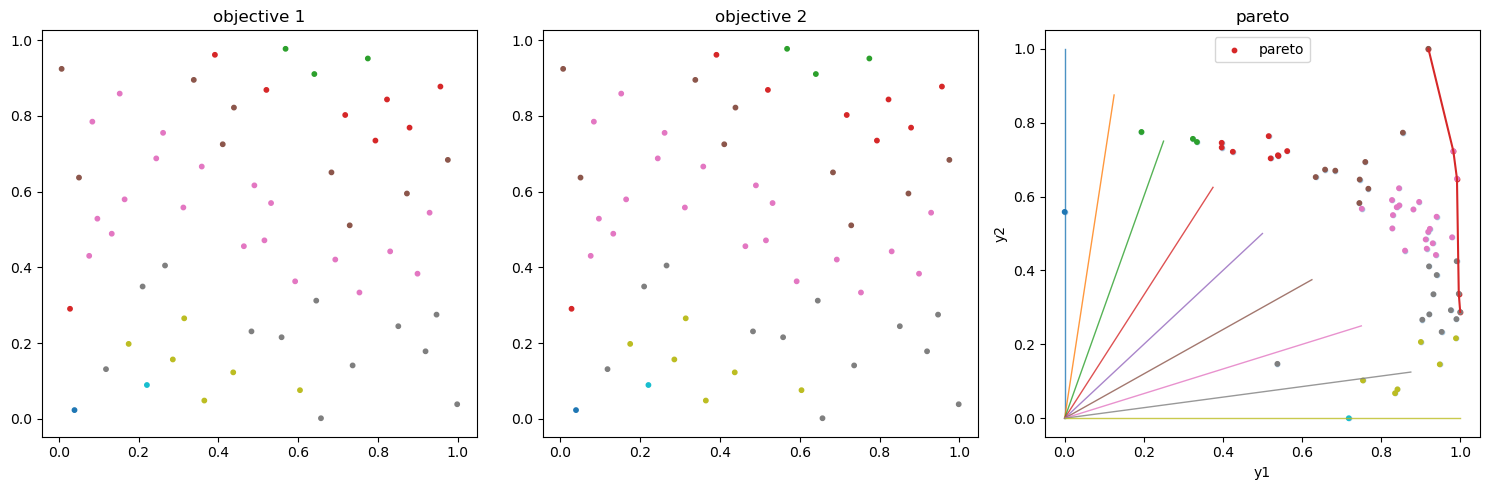

In [43]:
from pymoo.util.ref_dirs import get_reference_directions

fig = plt.figure(figsize=(15, 5))

boxes = [Rectangle(
    l_point.cpu(),
    *(u_point - l_point).cpu(),
    ) for l_point, u_point in zip(l, u)
]

axs = []
for i in range(n_objs):
    ax = plt.subplot2grid((1, n_objs + 1), (0, i))
    ax.set_title(f"objective {i + 1}")
    axs.append(ax)

ax_pareto = plt.subplot2grid((1, n_objs + 1), (0, n_objs))
plot_pareto_space(y_obs, pareto, ref_point=None, l=l, u_nbd=None, ax=ax_pareto, title='pareto')
ax_pareto.legend()


nadir_pt = compute_nadir_pt(y_obs)
# create the reference directions to be used for the optimization
ref_dirs = get_reference_directions("das-dennis", n_dim=2, n_partitions=8)
ref_dirs = torch.tensor(ref_dirs, **tkwargs)
# ref_vecs = sample_simplex(d=y_obs.shape[-1], n=10, qmc=True).to(**tkwargs)
ref_dirs -= nadir_pt
proj_len = torch.matmul(y_obs, ref_dirs.t())
l2_norm = torch.linalg.norm(ref_dirs, ord=2, dim=-1, keepdim=True)
proj_len /= l2_norm.t()
closest_dir = proj_len.argmax(dim=1)

for n, v in enumerate(ref_dirs):
    line = Line2D(
        [ref_point[0], v[0]],
        [ref_point[1], v[1]],
        linewidth=1, linestyle = "-",
        color=cmap(n),
        alpha=0.8,
    )
    ax_pareto.add_line(line)

c_list = torch.zeros(len(x_obs))
for d in closest_dir:
    idx = closest_dir == d
    c_list[idx] = d
axs[0].scatter(*x_obs.t(), c=c_list, cmap=cmap, s=10)
axs[1].scatter(*x_obs.t(), c=c_list, cmap=cmap, s=10)
ax_pareto.scatter(*y_obs.t(), c=c_list, cmap=cmap, s=10)

plt.tight_layout()

In [45]:
rhos, _ = cart2pol(y_obs[:, 1], y_obs[:, 0])
rhos = -rhos

tau = torch.quantile(rhos, q=1/3)

In [64]:
z = torch.less(rhos, tau).squeeze()
x_interest = x_obs[z]
y_interest = y_obs[z]
nadir_pt = compute_nadir_pt(y_obs)
ref_dirs = get_reference_directions("das-dennis", n_dim=problem.dim, n_partitions=8)
ref_dirs = torch.tensor(ref_dirs, **tkwargs)
ref_dirs -= nadir_pt
proj_len = torch.matmul(y_interest, ref_dirs.t())
l2_norm = torch.linalg.norm(ref_dirs, ord=2, dim=-1, keepdim=True)
proj_len /= l2_norm.t()

angle_count = torch.zeros_like(proj_len)
for i in range(proj_len.shape[0]):
   max_len = proj_len[i].max()
   angle_count[i] = (proj_len[i] == max_len)

y_angle = torch.matmul(angle_count, angle_count.sum(dim=0))

In [12]:
dir_classes = closest_dir.unique()
angles_class = torch.nn.functional.one_hot(closest_dir.squeeze().long(), num_classes=len(dir_classes)).to(**tkwargs)
model = MLP(input_dim=2, output_dim=len(dir_classes))
model.to(**tkwargs)

optimizer = torch.optim.AdamW(model.parameters())
loss_fn = torch.nn.CrossEntropyLoss()

# add batch dimension
train_tensors = [x_obs, angles_class]
train_dataset = torch.utils.data.TensorDataset(*train_tensors)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True
)

model.train()
for epochs in range(1000):
    for _, (inputs, targets) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(inputs)
        batch_loss = loss_fn(outputs, targets)
        batch_loss.backward()
        optimizer.step()
model.eval()

MLP(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=9, bias=True)
  )
)

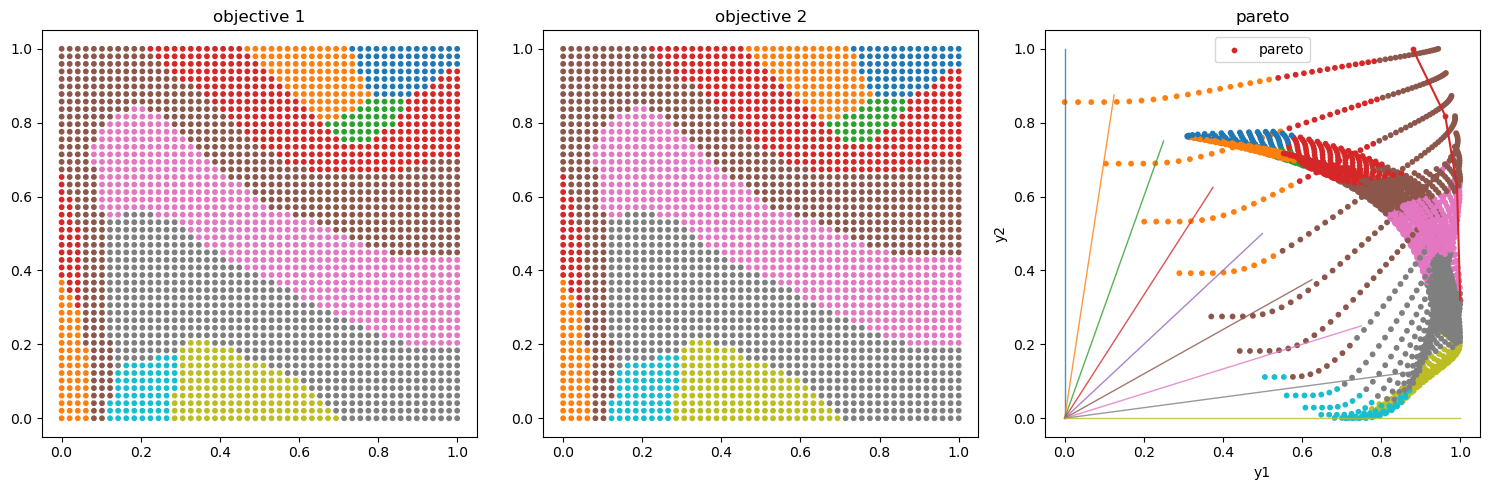

In [22]:
fig = plt.figure(figsize=(15, 5))

boxes = [Rectangle(
    l_point.cpu(),
    *(u_point - l_point).cpu(),
    ) for l_point, u_point in zip(l, u)
]

axs = []
for i in range(n_objs):
    ax = plt.subplot2grid((1, n_objs + 1), (0, i))
    ax.set_title(f"objective {i + 1}")
    axs.append(ax)

ax_pareto = plt.subplot2grid((1, n_objs + 1), (0, n_objs))
plot_pareto_space(y_obs=None, pareto=pareto, ref_point=None, l=l, u_nbd=None, ax=ax_pareto, title='pareto')
ax_pareto.legend()

with torch.no_grad():
    pred = model(input_data)
softmax_pred = torch.nn.functional.softmax(pred, dim=1)
class_pred = softmax_pred.argmax(dim=1)

for n, v in enumerate(ref_dirs):
    line = Line2D(
        [ref_point[0], v[0]],
        [ref_point[1], v[1]],
        linewidth=1, linestyle = "-",
        color=cmap(n),
        alpha=0.8,
    )
    ax_pareto.add_line(line)

output_data = normalize(output_data)
c_list = torch.zeros(len(input_data))
for d in closest_dir:
    idx = class_pred == d
    c_list[idx] = d
axs[0].scatter(*input_data.t(), c=c_list, cmap=cmap, s=10)
axs[1].scatter(*input_data.t(), c=c_list, cmap=cmap, s=10)
ax_pareto.scatter(*output_data.t(), c=c_list, cmap=cmap, s=10)

plt.tight_layout()

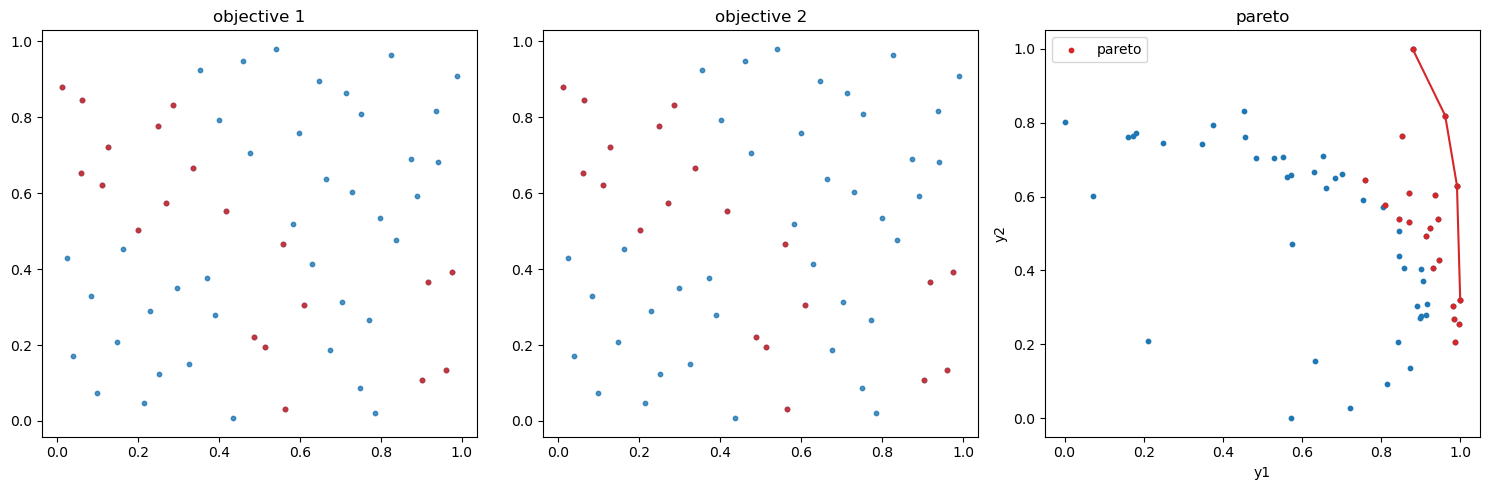

In [14]:
x_l_train, y_l_train, z_l_train, w_l_train = split_good_bad(x_obs, y_obs, gamma=1/3)

fig = plt.figure(figsize=(15, 5))

boxes = [Rectangle(
    l_point.cpu(),
    *(u_point - l_point).cpu(),
    ) for l_point, u_point in zip(l, u)
]

axs = []
for i in range(n_objs):
    ax = plt.subplot2grid((1, n_objs + 1), (0, i))
    ax.set_title(f"objective {i + 1}")
    axs.append(ax)

ax_pareto = plt.subplot2grid((1, n_objs + 1), (0, n_objs))
plot_pareto_space(y_obs=None, pareto=pareto, ref_point=None, l=l, u_nbd=None, ax=ax_pareto, title='pareto')
good_class = x_l_train[z_l_train.squeeze()]
bad_class = x_l_train[~z_l_train.squeeze()]
ax_pareto.scatter(*y_l_train[~z_l_train.squeeze()].t(), s=10, color='tab:blue')
ax_pareto.scatter(*y_l_train[z_l_train.squeeze()].t(), s=10, color='tab:red')
ax_pareto.legend()

axs[0].scatter(*bad_class.t(), s=10, color="tab:blue", alpha=.8)
axs[0].scatter(*good_class.t(), s=10, color="tab:red", alpha=.8)
axs[1].scatter(*bad_class.t(), s=10, color="tab:blue", alpha=.8)
axs[1].scatter(*good_class.t(), s=10, color="tab:red", alpha=.8)

plt.tight_layout()